# Predict Credit Card Churning Customers

* **Problem Statement:** A bank manager is uncomfortable with more and more customers leaving their credit card services. 

* **Goal:** Predict customers who are likely drop off from credit card services(going to churn) for a bank so that they can proactively go to the customer to provide them better services and turn customers' decisions in the opposite direction.

* **Advantage:** Data is clean, so relatively less time to spend on data cleaning and more time on modelling

* **Disadvantage:** Data is unbalanced; only 16.07% of customers churned. Thus, it's a bit difficult to train our model to predict churning customers.


I am going to apply **5 Supervised Machine Learning models** on the given dataset to predict churning customers.

The strategy is to apply default model first with no tuning of the hyperparameter and then tuned them with different hyperparameter values and compare them by their "**Recall**" value because goal is to **decrease False Negative number** because **we don’t want to lose any client**. If client churns, we want to predict correctly (as churned = 1). High Recall/Sensitivity has a low False Negative rate, so that we want to increase Recall.

The models used are as follows: 
1. **Logistic Regression**
2. **Ridge Classifier**
3. **KNeighborsClassifier**
4. **Random Forest**
5. **XGBoost**

# *Exploratory Data Analysis*

## Import Libraries & Data

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
bankchurners = pd.read_csv("/kaggle/input/credit-card-customers/BankChurners.csv")
bankchurners

## List Variables

In [ ]:
bankchurners.columns

In [ ]:
# in data description, it says ignore last 2 columns(Naive_Bayes_Class..)
# see here: https://www.kaggle.com/sakshigoyal7/credit-card-customers
# so that I'm dropping them
bankchurners.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis=1, inplace=True)

In [ ]:
bankchurners.info()

In [ ]:
bankchurners.isnull().sum()

In [ ]:
bankchurners.describe()

In [ ]:
bankchurners._get_numeric_data()

In [ ]:
# Droping CLIENTNUM columns because Client numberis unique identifier for the customer holding the account
# So this number doesn't really effect our churn prediction.
bankchurners.drop(['CLIENTNUM'], axis=1, inplace=True)

In [ ]:
# All columns
cols = bankchurners.columns
# Find numerical columns
num_cols = bankchurners._get_numeric_data().columns
num_cols

In [ ]:
# Categorical Columns
categorical = list(set(cols) - set(num_cols))
categorical

## About Data
**10127 rows x 21 columns**

**7 categorical features**
* Customer_id
* Attrition_Flag (1: Existing Customer, 0: Attrited Customer): The Customer leave or not
* Gender (1: Male, 0: Female)
* Education_Level (Graduate , High School, Unknown, Uneducated, College, Post-Graduate, Doctorate)
* Marital_Status (Married, Single, Unknown, Divorced)
* Income_Category (Less than 40K, 40K - 60K, 80K - 120K, 60K - 80K, Unknown, 120K +) in dollar
* Card_Category (Blue, Silver, Gold, Platinum)

**14 numerical features:**
* Customer_Age: Customer's Age in Years
* Dependent_count: Number of dependents
* Months_on_book: Period of relationship with bank
* Total_Relationship_Count: Total no. of products held by the customer
* Months_Inactive_12_mon: No. of months inactive in the last 12 months
* Contacts_Count_12_mon: No. of Contacts in the last 12 months
* Credit_Limit: Credit Limit on the Credit Card
* Total_Revolving_Bal: Total Revolving Balance on the Credit Card
* Avg_Open_To_Buy: Open to Buy Credit Line (Average of last 12 months)
* Total_Amt_Chng_Q4_Q1: Change in Transaction Amount (Q4 over Q1)
* Total_Trans_Amt: Total Transaction Amount (Last 12 months)
* Total_Trans_Ct: Total Transaction Count (Last 12 months)
* Total_Ct_Chng_Q4_Q1: Change in Transaction Count (Q4 over Q1)
* Avg_Utilization_Ratio: Average Card Utilization Ratio


In [ ]:
# Plot categorical columns
def pltCountplot(cat, df):
    
    fig, axis = plt.subplots(len(cat) // 2, 2, figsize=(20,16))  

    index = 0
    sns.set()
    for i in range(len(cat) // 2):
            
        for j in range(2):

            ax = sns.countplot(cat[index], data=df, ax=axis[i][j]);
        
            #for item in ax.get_xticklabels():
            #    item.set_rotation(15)

            for p in ax.patches:
                height = p.get_height()
                ax.text(p.get_x()+p.get_width(), height + 3, '{:1.2f}%'.format(height/len(df)*100), ha="center", fontsize=14) 
            
            index += 1

In [ ]:
# Plot categorical columns
pltCountplot(categorical, bankchurners);

We can see in the card category, generally clients use Blue card.

In [ ]:
bankchurners['Attrition_Flag'].value_counts()

In [ ]:
# as we can see here, only 16.07% of customers who have churned.
sns.countplot('Attrition_Flag', data=bankchurners)

As we can see here, dataset is not equally distribute according to Attrition_Flag. Only **16.07%** of customers who have churned among 10k clients.

In [ ]:
# Plot categorical columns with different y
def pltcrosstab(cat, df):
    
    fig, axis = plt.subplots((len(cat) // 3), 3, figsize=(16,8))  
    fig.tight_layout()

    index = 0
    sns.set()
    for i in range((len(cat) // 3)):
            
        for j in range(3):
            
            # Since we have 11 numerical columns, some plots will be empty
            if index == len(cat):
                break
            
            ax = pd.crosstab(df[cat[index]], df['Attrition_Flag']).plot(kind='bar', ax=axis[i][j])
        
            for item in ax.get_xticklabels():
                item.set_rotation(20)

            for p in ax.patches:
                height = p.get_height()
                ax.text(p.get_x()+p.get_width(), height + 3, '{:1.2f}%'.format(height/len(df)*100), ha="center", fontsize=8) 
            
            index += 1
            
    plt.subplots_adjust(wspace=0.2, hspace=0.4)

In [ ]:
# Plot categorical columns with different Attrition_Flag
pltcrosstab(categorical, bankchurners);

We can see in above plots, with different attrention_flag, how our categorical values change and also can see in which categiries we seeing churning customers the most.

* **%93.17** of churned clients have Blue card
* **%35.15** of churned clients have less than $40K 
* **%46.28** of churned clients are married
* **%30.88** of churned clients have graduate education level

In [ ]:
# Check distribution of numerical features
bankchurners.hist(figsize=(30,16), xrot=15, bins=int(bankchurners.shape[0]**0.5));

In [ ]:
from scipy.stats import norm
def plotDistPlot(df, columns):
    fig, ax = plt.subplots(len(columns)//3, 3,figsize=(20, 12))
    
    index = 0
    for i in range(2):
        for j in range(3):
            sns.distplot(df.loc[:, columns[index]],
                         hist=True,
                         fit=norm,
                         kde=True,
                         ax=ax[i][j])
            ax[i][j].set_title(columns[index])
            ax[i][j].legend(labels=['Normal', 'Actual'])
            index += 1

In [ ]:
some_columns = ['Customer_Age','Credit_Limit','Months_on_book','Avg_Utilization_Ratio','Avg_Open_To_Buy','Total_Trans_Amt']
plotDistPlot(bankchurners, some_columns)

In [ ]:
bankchurners.plot(kind='box', figsize = (18,10), rot=30, showfliers=False);

In [ ]:
# Check distribution of numerical features
sns.pairplot(bankchurners, hue='Attrition_Flag', height=2.5)

Here we can see all numerical columns and Attrition_Flag distribution

In [ ]:
sns.pairplot(bankchurners, vars=['Total_Trans_Amt','Total_Trans_Ct'], hue='Attrition_Flag', height=2.5)

This one is interesting that found in above pairplot of numerical columns, people who churned from credit card service, had less transaction count and transaction amount!


## Check Correlation

In [ ]:
num_cols = bankchurners._get_numeric_data().columns
corr_data = bankchurners.loc[:, num_cols].corr()

plt.figure(figsize=(20,12))
sns.heatmap(corr_data.abs(), annot=True, fmt='.3f',cmap='coolwarm',square=True)
plt.show()

`Months_on_book` seems like correlated with `Customer_Age` .

`Total Transaction Count` is correlated with `Total Transaction Amount`.

## Feature Engineering

Change categorical Attrition_Flag feature to numerical feature and rename it as churn.

In [ ]:
# tag churned users as 1, rest as 0 and rename column
bankchurners['Attrition_Flag'].replace(('Existing Customer','Attrited Customer'), (0,1), inplace=True)

In [ ]:
bankchurners.rename(columns={'Attrition_Flag':'churn'}, inplace=True)

In [ ]:
bankchurners['Income_Category'].value_counts()

In [ ]:
bankchurners['churn'].value_counts()

In [ ]:
# If I remove unknown data from income_category, i'm losing 11% of my data, so I'm leaving it.
bankchurners[bankchurners['Income_Category']!='Unknown']['churn'].value_counts()

In [ ]:
# If I removed all 'unknown' data, I lose more than %30 of my data, so I'm going to leave them
bankchurners[(bankchurners['Income_Category']!='Unknown') & (bankchurners['Education_Level']!='Unknown') & (bankchurners['Marital_Status']!='Unknown')]['churn'].value_counts()

Convert income category to numerical values(preferred to give order depending on their income category instead of get dummies to avoid increasing the dataset size)

In [ ]:
# Wanted to order income category because I didn't want to increase my feature column numbers by getting dummies from income category
bankchurners_df = bankchurners.copy()
bankchurners_df['Income_Category'] = bankchurners_df['Income_Category'].replace({'Unknown': 0 ,'Less than $40K':1, '$40K - $60K':2, 
                                                      '$80K - $120K':3, '$60K - $80K':4, '$120K +':5})

In [ ]:
bankchurners_df.info()

#### Get dummies for rest of the categorical features.

In [ ]:
categorical = bankchurners_df.select_dtypes(include='object').columns
bankchurners_df = pd.get_dummies(bankchurners_df, columns = categorical, drop_first=True)

In [ ]:
bankchurners_df.info()

#### Examine the correlations between the features and the target.

In [ ]:
# Examine the correlations between the features and the target.
corr = bankchurners_df.select_dtypes(include=[np.number]).corr()
print (corr['churn'].sort_values(ascending=False)[:5], '\n')
print (corr['churn'].sort_values(ascending=False)[-5:])

#### Check corralated features with eachother

In [ ]:
# Check corralated features with eachother
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.select_dtypes(include=[np.number]).columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    corr = df.select_dtypes(include=[np.number]).corr()
    au_corr = corr.abs().unstack()
    labels_to_drop = get_redundant_pairs(df.select_dtypes(include=[np.number]))
    #From corrolation table, drop the diagonals(which gives 1 corr)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(bankchurners_df, 10))

## Modelling

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

First let's built and try it on simple model.

In [ ]:
# set x and y
X = bankchurners_df.drop('churn', axis = 1)
y = bankchurners_df['churn']

# train test split
# stratify=y preserve the proportion of target as in orginal dataset in the train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99, stratify=y)

# set the model
logreg = LogisticRegression()

# fit model
logreg.fit(X_train, y_train)

In [ ]:
# Baseline accuracy = proportion of the majority class
print('Baseline Accuracy: ',1. - y_train.mean())
print('Train Accuracy :',logreg.score(X_train, y_train))
print('Test Accuracy: ',logreg.score(X_test, y_test))

In [ ]:
# confusion matrix
y_pred = logreg.predict(X_test)
cf = metrics.confusion_matrix(y_test, y_pred)
pd.DataFrame(cf, columns=['pred neg','pred pos'], index=['actual neg','actual pos'])

In [ ]:
from IPython import display
def confisuon_matrix_summary(y_test, model, treshold):
    
    model_pred_proba = model.predict_proba(X_test)[:,1]
    cf = metrics.confusion_matrix(y_true=y_test, y_pred=model_pred_proba > treshold)
    cm = pd.DataFrame(cf, columns=['pred neg','pred pos'], index=['actual neg','actual pos'])
    
    display.display(cm)
    
    print('Classification treshold is ', treshold)
    # Recall, also known as the sensitivity, hit rate, or the true positive rate (TPR), is the proportion of the total amount of relevant instances that were actually retrieved. 
    # It answers the question “What proportion of actual positives was identified correctly?”
    print('True Positive Rate/Recall = TP/(TP+FN) :', cf[1][1] / (cf[1][1] + cf[1][0]))     #same as metrics.recall_score(y_test,y_pred)
    print('False Positive Rate = FP/(FP+TN) :', cf[0][1] / (cf[0][1] + cf[0][0]))
    # Accuracy - ratio of correctly predicted observation to the total observations.
    print('Accuracy = (TP+TN)/total :', (cf[1][1]+cf[0][0])/(cf[1][1]+cf[0][0]+cf[0][1]+cf[1][0]))
    # Precision - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations
    # It answers the question “What proportion of positive identifications was actually correct?”
    print('Precision = TP/(TP+FP) :',  (cf[1][1]/(cf[1][1]+cf[0][1])))   #same as metrics.precision_score(y_test,y_pred)
    
confisuon_matrix_summary(y_test, logreg, 0.5)

In [ ]:
from IPython import display
# normalise confusion matrix with 'weighted'(calculate metrics for each label) precisions
def verify_performance(y_true, y_pred, model, display_matrix=True):
    print(f"Weighted Average Precision: {metrics.precision_score(y_true, y_pred, average='weighted'):.4f}")  
    confusion_matrix = pd.DataFrame(
        metrics.confusion_matrix(y_true, y_pred, normalize='true'),
        index=model.classes_, columns=model.classes_).round(2)
      
    display.display(pd.Series(
        np.diagonal(confusion_matrix.T), 
        index=confusion_matrix.index, 
        name='individual precision').to_frame().T)
  
    if display_matrix:
        display.display(confusion_matrix)
        
verify_performance(y_test, y_pred, logreg)

In [ ]:
# We can vary the classification threshold for our model to get different predictions.
# By setting a lower probability threshold we will predict more positive classes. Which means we will predict more true positives, but fewer true negatives.

# confusion matrix (changing threshold to 0.4)
confisuon_matrix_summary(y_test, logreg, 0.4)

In [ ]:
logreg_pred_proba = logreg.predict_proba(X_test)[:,1]
verify_performance(y_test, logreg_pred_proba > .4, logreg)

Seems like chaning treshtold didn't increase out precision, let's try another algorithm

In [ ]:
# Examine the intercept.
logreg.intercept_

In [ ]:
# Examine the coefficients.
# The higher the coefficient, the higher the “importance” of a feature.

coefficients = list(zip(X_train.columns, logreg.coef_[0]))
coefficients

In [ ]:
# K-folds Cross Validation
from sklearn.model_selection import cross_val_score

def cross_val_accuracy_precision(model, X, y):
    acc = []
    precisions=[]
    recalls=[]
    for n in range(5,10):

        # Note the results will vary each run since we take a different
        # subset of the data each time (since shuffle=True)
        scores = np.mean(cross_val_score(model, X, y, cv=n, scoring='accuracy'))
        acc.append(scores)
        p = np.mean(cross_val_score(model, X, y, cv=n, scoring=metrics.make_scorer(metrics.precision_score, average='weighted')))
        precisions.append(p)
        r = np.mean(cross_val_score(model, X, y, cv=n, scoring=metrics.make_scorer(metrics.recall_score, average='weighted')))
        recalls.append(r)
        print('Mean of Accuracy for all ', str(n), ' folds: ', 'Accuracy: ', scores)
        print('Mean of Precision ', str(n), ' folds: ', 'Precision: ', p)
        print('Mean of Recall ', str(n), ' folds: ', 'Recall: ', r)
        
    # plot to see clearly
    plt.plot(range(5,10), acc)
    plt.xlabel('n split')
    plt.ylabel('Mean of Accuracy for all folds')
    plt.show();
    plt.plot(range(5,10), precisions)
    plt.xlabel('n split')
    plt.ylabel('Weighted Average Precision')
    plt.show();
    plt.plot(range(5,10), recalls)
    plt.xlabel('n split')
    plt.ylabel('Weighted Average Recall')
    plt.show();
    
logreg_cv=LogisticRegression()
cross_val_accuracy_precision(logreg_cv, X, y)

Now let's try to tune parameters and see if we going to get better recall.

#### Parameter Tuning with GridSearch

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([('classifier' , LogisticRegression())])
# pipe = Pipeline([('classifier', RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']}]

clf = GridSearchCV(pipe, 
                   param_grid = param_grid, 
                   cv = 5, 
                   scoring=metrics.make_scorer(metrics.recall_score), # maximise recall to minimise FN
                   return_train_score=True,
                   n_jobs=-1,
                   verbose=True)
clf.fit(X, y)  
clf.best_estimator_

In [ ]:
# set x and y
X = bankchurners_df.drop('churn', axis = 1)
y = bankchurners_df['churn']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99, stratify=y)

# set the model
logreg = LogisticRegression(C=3792.690190732246, penalty='l1',
                                    solver='liblinear')

# fit model
logreg.fit(X_train, y_train)

In [ ]:
confisuon_matrix_summary(y_test, logreg, 0.5)       

In [ ]:
verify_performance(y_test, y_pred, logreg)

This isn't the best recall, let's check another model!

### Ridge Classifier

Let's create simple Ridge model

In [ ]:
# RidgeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import StandardScaler

# set x and y
X = bankchurners_df.drop('churn', axis = 1)
y = bankchurners_df['churn']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

ridge = RidgeClassifier()
ridge.fit(X_train, y_train)

In [ ]:
print('Train Accuracy :',ridge.score(X_train, y_train))
print('Test Accuracy: ',ridge.score(X_test, y_test))

In [ ]:
# Baseline accuracy = proportion of the majority class
1. - y_train.mean()

In [ ]:
from IPython import display
def confisuon_matrix_summary_ridge(y_test, model):
    # confusion matrix
    y_pred = model.predict(X_test)
    cf = metrics.confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(cf, columns=['pred neg','pred pos'], index=['actual neg','actual pos'])

    display.display(cm)
    
    print('Classification treshold is 0.5')
    # Recall, also known as the sensitivity, hit rate, or the true positive rate (TPR), is the proportion of the total amount of relevant instances that were actually retrieved. 
    # It answers the question “What proportion of actual positives was identified correctly?”
    print('True Positive Rate/Recall = TP/(TP+FN) :', cf[1][1] / (cf[1][1] + cf[1][0]))     #same as metrics.recall_score(y_test,y_pred)
    print('False Positive Rate = FP/(FP+TN) :', cf[0][1] / (cf[0][1] + cf[0][0]))
    # Accuracy - ratio of correctly predicted observation to the total observations.
    print('Accuracy = (TP+TN)/total :', (cf[1][1]+cf[0][0])/(cf[1][1]+cf[0][0]+cf[0][1]+cf[1][0]))
    # Precision - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations
    # It answers the question “What proportion of positive identifications was actually correct?”
    print('Precision = TP/(TP+FP) :',  (cf[1][1]/(cf[1][1]+cf[0][1])))   #same as metrics.precision_score(y_test,y_pred)
confisuon_matrix_summary_ridge(y_test, ridge)

In [ ]:
y_pred = ridge.predict(X_test)
verify_performance(y_test, y_pred, ridge)

Let's see if we can improve our model by changing our parameters!

#### Parameter Tuning with GridSearch

In [ ]:
from sklearn.pipeline import make_pipeline
acc = []
precisions=[]
for n in range(5,10):
    
    pipe = make_pipeline(StandardScaler(), RidgeClassifier())

    # Note the results will vary each run since we take a different
    # subset of the data each time (since shuffle=True)
    scores = np.mean(cross_val_score(pipe, X, y, cv=n, scoring='accuracy'))
    acc.append(scores)
    p= np.mean(cross_val_score(pipe, X, y, cv=n, scoring=metrics.make_scorer(metrics.precision_score, average='weighted')))
    precisions.append(p)
    print('Mean of Accuracy for all ', str(n), ' folds: ', 'Scores: ', scores)
    print('Mean of Precision ', str(n), ' folds: ', 'Precision: ', p)

# plot to see clearly
plt.plot(range(5,10), acc)
plt.xlabel('n split')
plt.ylabel('Mean of Accuracy for all folds')
plt.show();
plt.plot(range(5,10), precisions)
plt.xlabel('n split')
plt.ylabel('Weighted Average Precision')
plt.show();

In [ ]:
# Parameter Tuning with ridge error
def rmse_ridge(ridge_model):
    ridge_model.fit(X_train, y_train)
    ridge_pre = ridge_model.predict(X_test)
    squared = np.square(ridge_pre-y_test)
    ridge_error = np.sqrt(np.sum(squared)/len(y_test))
    return(ridge_error)

alphas = [0.01, 0.02, 0.1, 0.3, 1, 3, 5, 10, 20, 30,40,100]
cv_ridge = [rmse_ridge(RidgeClassifier(alpha = alpha )).mean() 
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = " Parameter tuning - Ridge")
cv_ridge.min()

In [ ]:
import joblib
joblib.parallel_backend('threading')
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold

pipe=make_pipeline(StandardScaler(),RidgeClassifier()) #, class_weight='balanced'

grid_search = GridSearchCV(
    pipe, 
    {'ridgeclassifier__alpha': range(0,100)},  # Tried [0, 0.001, 0.01, 0.1, 0.5, 1, 1.5, 100] as well
    cv=StratifiedKFold(10, random_state=10, shuffle=True),
    scoring=metrics.make_scorer(metrics.recall_score), # maximise recall to minimise FN
    return_train_score=True,
    n_jobs=-1,
    verbose=3)

#X_sc = scaler.transform(X)  # can use this if I don't use pipe
grid_search.fit(X, y)
grid_search.best_estimator_

* **Maximize recall:** best value found in **alpha = 0**
* **Maximize precision:** best value found **in alpha = 97**
* **Maximize accuracy:** best value found **in alpha = 5**

Let's run the model with those alphas to see if we going to get any better recall, precision or accuracy.

In [ ]:
# set x and y
X = bankchurners_df.drop('churn', axis = 1)
y = bankchurners_df['churn']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Ridge with alpha = 0
ridge = RidgeClassifier(alpha=0) #, class_weight='balanced'
ridge.fit(X_train, y_train)

In [ ]:
print('Train Accuracy :',ridge.score(X_train, y_train))
print('Test Accuracy: ',ridge.score(X_test, y_test))

In [ ]:
confisuon_matrix_summary_ridge(y_test, ridge)

In [ ]:
y_pred = ridge.predict(X_test)
verify_performance(y_test, y_pred, ridge)

In [ ]:
# set x and y
X = bankchurners_df.drop('churn', axis = 1)
y = bankchurners_df['churn']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Ridge with alpha = 0
ridge = RidgeClassifier(alpha=0, class_weight='balanced')
ridge.fit(X_train, y_train)

In [ ]:
print('Train Accuracy :',ridge.score(X_train, y_train))
print('Test Accuracy: ',ridge.score(X_test, y_test))

In [ ]:
confisuon_matrix_summary_ridge(y_test, ridge)

In [ ]:
y_pred = ridge.predict(X_test)
verify_performance(y_test, y_pred, ridge)

We didn't get better recall value, actualy it was worse than previous logistic regression model(recall was 0.5773 in logreg) and now we got 0.4742 recall with ridge. Let's look at another model!

### KNN Classifier

Let's start with simple KNN model.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# set x and y
X = bankchurners_df.drop('churn', axis = 1)
y = bankchurners_df['churn']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=14)
knn.fit(X_train, y_train)

In [ ]:
print('Train Accuracy :',knn.score(X_train, y_train))
print('Test Accuracy: ',knn.score(X_test, y_test))

In [ ]:
most_freq_class = y_train.value_counts().index[0]
#Compute null accuracy.
y_test.value_counts()[most_freq_class] / len(y_test)

In [ ]:
confisuon_matrix_summary(y_test, knn, 0.5)

In [ ]:
knn_pred_proba = knn.predict_proba(X_test)[:,1]
verify_performance(y_test, knn_pred_proba > .5, knn)

In [ ]:
scores = []
for k in range(1,101):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    pred = knn.predict(X_test)
    # Score with accuracy
    score = float(sum(pred == y_test)) / len(y_test)
    scores.append([k, score])

In [ ]:
#maximize accuracy
data = pd.DataFrame(scores,columns=['k','score'])
data.plot.line(x='k',y='score');

**Maximize accuracy:** best value found in **k=5**

In [ ]:
scores = []
for k in range(1,101):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    pred = knn.predict(X_test)
    # Score with precision
    score = metrics.precision_score(y_test,knn.predict(X_test))
    scores.append([k, score])

In [ ]:
#miximize precision
data = pd.DataFrame(scores,columns=['k','score'])
data.plot.line(x='k',y='score');

**Maximize precision:** best value found in **k=99**

In [ ]:
# Calculate TRAINING ERROR and TESTING ERROR for K=1 through 100

k_range = list(range(1, 101))
training_error = []
testing_error = []

# Find test accuracy for all values of K between 1 and 100 (inclusive).
for k in k_range:

    # Instantiate the model with the current K value.
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Calculate training error (error = 1 - accuracy).
    y_pred_class = knn.predict(X_train)
    training_accuracy = metrics.accuracy_score(y_train, y_pred_class)
    training_error.append(1 - training_accuracy)
    
    # Calculate testing error.
    y_pred_class = knn.predict(X_test)
    testing_accuracy = metrics.accuracy_score(y_test, y_pred_class)
    testing_error.append(1 - testing_accuracy)

In [ ]:
# Create a DataFrame of K, training error, and testing error.
column_dict = {'K': k_range, 'training error':training_error, 'testing error':testing_error}
df = pd.DataFrame(column_dict).set_index('K').sort_index(ascending=False)
df.head()

In [ ]:
# Plot the relationship between K (HIGH TO LOW) and TESTING ERROR.
# Best k number is where Testing error is min
df.plot(y='testing error');
plt.xlabel('Value of K for KNN');
plt.ylabel('Error (lower is better)');

In [ ]:
min(list(zip(testing_error, k_range)))

In [ ]:
# Plot the relationship between K (HIGH TO LOW) and both TRAINING ERROR and TESTING ERROR.
df.plot();
plt.xlabel('Value of K for KNN');
plt.ylabel('Error (lower is better)');


Training error decreases as model complexity increases (lower value of K).

Testing error is minimized at the optimum model complexity.

In [ ]:
from sklearn.pipeline import make_pipeline
k_scores = []

# choose k between 1 to 49, step 2 to get odds
# use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for k in range(1, 100):
    knn = KNeighborsClassifier(n_neighbors=k)
    
    pipe = make_pipeline(StandardScaler(), knn)
    cv=StratifiedKFold(5, random_state=10, shuffle=True)
    scores = cross_val_score(pipe, X, y, cv=cv, scoring=metrics.make_scorer(metrics.recall_score)) #scoring=metrics.make_scorer(metrics.precision_score)
    k_scores.append(scores.mean())

# plot to see clearly
plt.plot(range(1, 100), k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Recall')
plt.show();

In [ ]:
max_acc = max(k_scores)
for i, acc in zip(range(1, 100), k_scores):
    if acc == max_acc:
        print('k: ', i)
        print('max_recall: ', acc)

**Maximize recall:** scoring=metrics.make_scorer(metrics.recall_score) best value found in **k=1**

**Maximize precision:** scoring=metrics.make_scorer(metrics.precision_score) best value found in **k=99**

**Maximize accuracy:** scoring='accuracy' best value found in** k=5 and 7**

Now built the model with k=1 to find best recall for KNN.

In [ ]:
# set x and y
X = bankchurners_df.drop('churn', axis = 1)
y = bankchurners_df['churn']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

In [ ]:
print('Train Accuracy :',knn.score(X_train, y_train))
print('Test Accuracy: ',knn.score(X_test, y_test))

In [ ]:
confisuon_matrix_summary(y_test, knn, 0.5)

In [ ]:
knn_pred_proba = knn.predict_proba(X_test)[:,1]
verify_performance(y_test, knn_pred_proba > .5, knn)

0.5012 is not what we are looking for, I believe we can find better recall! Let's look at another model!

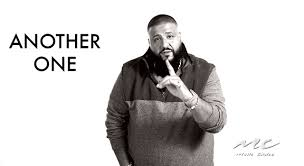

### Random Forest

Let's start with simple random forest mode. I'm bit scared that It'll overfit but c'est la vie.. :)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# set x and y
X = bankchurners_df.drop('churn', axis = 1)
y = bankchurners_df['churn']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99, stratify=y)

#Create a Random Forest Classifier
rfc=RandomForestClassifier(n_estimators=100, random_state = 42)

#Train the model using the training sets
rfc.fit(X_train,y_train)

In [ ]:
print('Train Accuracy :',metrics.accuracy_score(y_train, rfc.predict(X_train)))
print('Test Accuracy: ',metrics.accuracy_score(y_test, rfc.predict(X_test)))

Yup! It did overfit, but good new is test set prediction doesn't look bad at all!

In [ ]:
confisuon_matrix_summary(y_test, rfc, 0.5)

In [ ]:
rfc_pred_proba = rfc.predict_proba(X_test)[:,1]
verify_performance(y_test, rfc_pred_proba > .5, rfc)

Oh awesome, we are getting somewhere! Recall is 0.823 yeey! Let's tune this bad boi and see if we can increase this!

In [ ]:
n_estimators = [100, 200, 300]
max_depth = [5, 10,  25]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 5, 10]
#ccp_alpha = [0, 0.01, 0.1, 1]

hyperF = dict(n_estimators = n_estimators, 
              max_depth = max_depth, 
              min_samples_split = min_samples_split, 
              min_samples_leaf = min_samples_leaf)
             # ccp_alpha = ccp_alpha)

grid_search = GridSearchCV(RandomForestClassifier(), 
                           hyperF, 
                           cv=StratifiedKFold(5, random_state=10, shuffle=True),
                           scoring=metrics.make_scorer(metrics.recall_score),
                           verbose = 3, 
                           n_jobs = -1)

grid_search.fit(X, y)
grid_search.best_estimator_

In [ ]:
grid_search.best_estimator_

Let's try out new model with better parameters to get better recall score.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# set x and y
X = bankchurners_df.drop('churn', axis = 1)
y = bankchurners_df['churn']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99, stratify=y)

#Create a Random Forest Classifier
rfc=RandomForestClassifier(n_estimators=200, 
                           max_depth=25, 
                          # min_samples_leaf=5, 
                           min_samples_split=5, 
                           random_state = 42)

#Train the model using the training sets 
rfc.fit(X_train,y_train)

In [ ]:
print('Train Accuracy :',metrics.accuracy_score(y_train, rfc.predict(X_train)))
print('Test Accuracy: ',metrics.accuracy_score(y_test, rfc.predict(X_test)))

In [ ]:
confisuon_matrix_summary(y_test, rfc, 0.5)

In [ ]:
print('Train Accuracy :',metrics.accuracy_score(y_train, rfc.predict(X_train)))
print('Test Accuracy: ',metrics.accuracy_score(y_test, rfc.predict(X_test)))

In [ ]:
confisuon_matrix_summary(y_test, rfc, 0.5)

In [ ]:
rfc_pred_proba = rfc.predict_proba(X_test)[:,1]
verify_performance(y_test, rfc_pred_proba > .5, rfc)

I can't complain for this at all! 0.84 recall score and 0.9395 precison and 0.9656 accuracy is pretty good! 

But almost there, lastly I want to try it with more advanced model! Queen XGBoost!

### XGBoost

In [ ]:
import xgboost as xgb

# set x and y
X = bankchurners_df.drop('churn', axis = 1)
y = bankchurners_df['churn']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99, stratify=y)

# Create xgboost model
m_xgb = xgb.XGBClassifier(n_estimators=200,
                       max_depth=2, random_state=42)

#Train the model using the training sets
m_xgb.fit(X_train,y_train)

In [ ]:
print('Train Accuracy :',metrics.accuracy_score(y_train, m_xgb.predict(X_train)))
print('Test Accuracy: ',metrics.accuracy_score(y_test, m_xgb.predict(X_test)))

In [ ]:
confisuon_matrix_summary(y_test, m_xgb, 0.5)

In [ ]:
xgb_pred_proba = m_xgb.predict_proba(X_test)[:,1]
verify_performance(y_test, xgb_pred_proba > .5, rfc)

We got this! Recall: 0.9164, Precision: 0.9395, Accuracy: 0.9770 is pretty good model! I haven't tuned the model but it could be done for next step. Result seems very good!

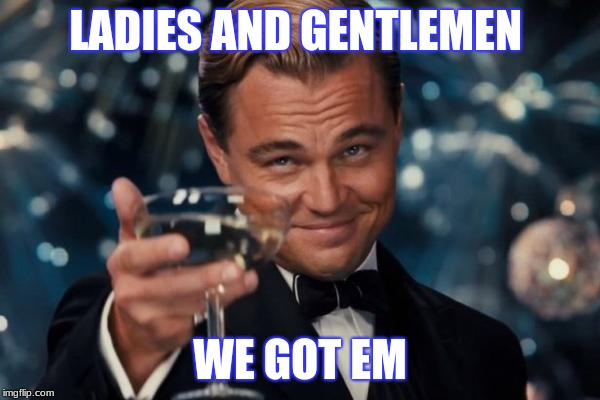

# Result

XGBoost gave the best recall score, precision and accuracy!

Logistic Regresion:
* **Recall**: 0.5773
* **Precison** Score: 0.7669
* **Accuracy**: 0.9040

Ridge Classifier:
* **Recall**: 0.4742
* **Precison** Score: 0.8772
* **Accuracy**: 0.9048

KNN:
* **Recall**: 0.5012
* **Precison** : 0.6017
* **Accuracy**: 0.8665

Random Forest:
* **Recall**: 0.8402
* **Precison** : 0.9395
* **Accuracy**: 0.9656

XGBoost:
* **Recall**: 0.9164
* **Precison** : 0.9395
* **Accuracy**: 0.9770



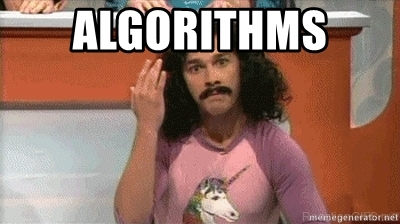